## Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

In [2]:
# Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Step 1: Loading the dataset
data = load_breast_cancer()
X, Y = data.data, data.target  # Features and target
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (569, 30)
Shape of Y: (569,)


In [4]:
#  Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
# Standardizing(scaling) the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Converting data into Pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

## Building Neural Network

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [8]:
#Initalizing the Hyperparameters
input_size = X_train.shape[1]  # 30 features
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 100

In [9]:
# Initializing the model
model = NeuralNet(input_size, hidden_size, output_size).to(device)

In [10]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the Model

In [11]:
training_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, Y_train.view(-1,1))
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    # Calculate accuracy
    with torch.no_grad():
        predicted = outputs.round()
        correct = (predicted == Y_train.view(-1,1)).float().sum()
        accuracy = correct / Y_train.size(0)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item()*100:.2f}%")


Epoch [10/100], Loss: 0.5037, Accuracy: 89.45%
Epoch [20/100], Loss: 0.3916, Accuracy: 92.75%
Epoch [30/100], Loss: 0.3088, Accuracy: 93.63%
Epoch [40/100], Loss: 0.2482, Accuracy: 94.07%
Epoch [50/100], Loss: 0.2047, Accuracy: 95.38%
Epoch [60/100], Loss: 0.1736, Accuracy: 95.60%
Epoch [70/100], Loss: 0.1508, Accuracy: 96.70%
Epoch [80/100], Loss: 0.1335, Accuracy: 97.36%
Epoch [90/100], Loss: 0.1201, Accuracy: 97.58%
Epoch [100/100], Loss: 0.1094, Accuracy: 97.80%


# Evaluating on the Test data

In [12]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = outputs.round()
    correct = (predicted == Y_test.view(-1,1)).float().sum()
    test_accuracy = correct / Y_test.size(0)
    print(f"Test Accuracy: {test_accuracy.item()*100:.2f}%")

Test Accuracy: 98.25%


# Confusion Matrix

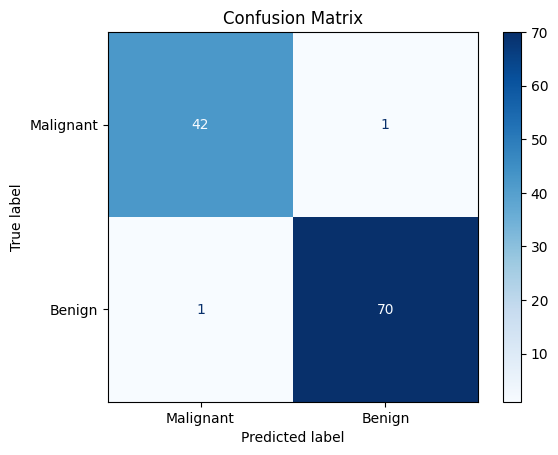

In [13]:
cm = confusion_matrix(Y_test.cpu().numpy(), predicted.cpu().numpy())
disp = ConfusionMatrixDisplay(cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ROC Curve

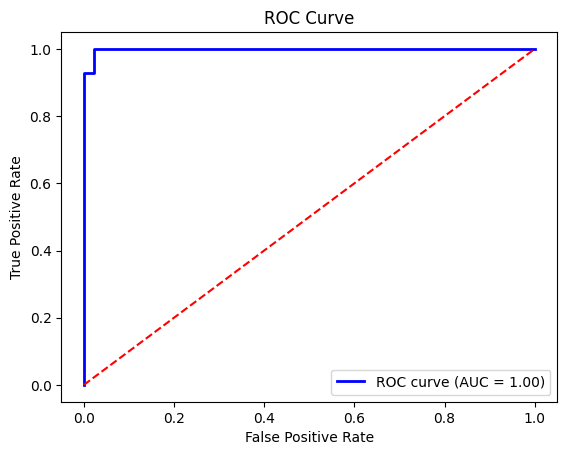

In [14]:
outputs_np = outputs.cpu().numpy()
fpr, tpr, _ = roc_curve(Y_test.cpu().numpy(), outputs_np)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Training Loss Curve

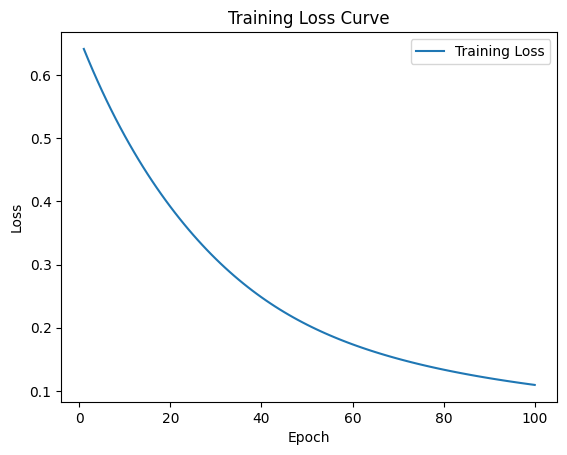

In [15]:
plt.figure()
plt.plot(range(1, num_epochs+1), training_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.savefig("training_curve.png")
plt.show()

In [16]:
#Save model and scaler
torch.save(model.state_dict(), "breast_cancer_model.pth")
joblib.dump(scaler, "scaler.pkl")
print("✅ Training complete. Model, scaler and plots saved successfully!")

✅ Training complete. Model, scaler and plots saved successfully!


## Testing Model on training and new data

In [17]:
def predict_cancer(model, input_data):
    """
    Correct mapping according to sklearn:
    0 = Malignant, 1 = Benign
    """
    model.eval()

    # Convert to tensor if input is numpy array
    if isinstance(input_data, np.ndarray):
        input_tensor = torch.from_numpy(input_data.astype(np.float32)).unsqueeze(0).to(device)
    elif isinstance(input_data, torch.Tensor):
        input_tensor = input_data.unsqueeze(0).to(device)  # add batch dimension
    else:
        raise ValueError("Input data must be a numpy array or torch tensor")

    with torch.no_grad():
        output = model(input_tensor)
        probability = output.item()  # probability for class 1 (Benign)
        prediction = round(probability)

    # Adjust labels
    if prediction == 1:
        return f"Prediction: Benign (Probability: {probability:.4f})"
    else:
        return f"Prediction: Malignant (Probability: {1-probability:.4f})"

In [19]:
for i in range(5):  # first 5 samples from training data
    sample_input = X_test[i]
    sample_label = Y_test[i]
    result = predict_cancer(model, sample_input)
    print(f"Sample {i+1}: Actual: {'Malignant' if sample_label==1 else 'Benign'}, Predicted: {result}")

Sample 1: Actual: Malignant, Predicted: Prediction: Benign (Probability: 0.7841)
Sample 2: Actual: Benign, Predicted: Prediction: Malignant (Probability: 0.9865)
Sample 3: Actual: Benign, Predicted: Prediction: Malignant (Probability: 0.9278)
Sample 4: Actual: Malignant, Predicted: Prediction: Benign (Probability: 0.9436)
Sample 5: Actual: Malignant, Predicted: Prediction: Benign (Probability: 0.9728)


In [20]:
# new raw data (list of 30 feature values)
new_sample = [
9.504, 12.44, 60.34, 273.9, 0.1024, 0.06492, 0.02956, 0.02076, 0.1815, 0.06905,
0.2773, 0.9768, 1.909, 15.7, 0.009606, 0.01432, 0.01985, 0.01421, 0.02027, 0.002968,
10.23, 15.66, 65.13, 314.9, 0.1324, 0.1148, 0.08867, 0.06227, 0.245, 0.07773
]


# Converting to numpy array and scale
import numpy as np
new_data_scaled = scaler.transform([new_sample])  # shape (1,30)

# Make prediction
result = predict_cancer(model, new_data_scaled[0])
print(result)

Prediction: Benign (Probability: 0.9963)


In [21]:
new_sample_1 = [
15.34, 14.26, 102.5, 704.4, 0.1073, 0.2135, 0.2077, 0.09756, 0.2521, 0.07032,
0.4388, 0.7096, 3.384, 44.91, 0.006789, 0.05328, 0.06446, 0.02252, 0.03672, 0.004394,
18.07, 19.08, 125.1, 980.9, 0.139, 0.5954, 0.6305, 0.2393, 0.4667, 0.09946
]

# Convert to numpy array and scale
import numpy as np
new_data_scaled = scaler.transform([new_sample_1])  # shape (1,30)

# Make prediction
result = predict_cancer(model, new_data_scaled[0])
print(result)

Prediction: Malignant (Probability: 0.9532)
